# Air Temperature Estimation Model Deployment

This notebook focuses on deploying the Air Temperature Estimation Model to output estimates on Google Earth Engine.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [768]:
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from model_functions import *

import ee
import geemap
from gee_functions import * # custom functions for GEE
from settings import * # global variables for GEE data download

from IPython.display import Image
import folium

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

import requests

import pickle
import dill

In [3]:
%load_ext autoreload
%autoreload 2

----

## Key Variables and Hyperparameters

First, we set the estimation hyperparameter of date for estimation (based on what is available for LST)

### Key Variables

In [851]:
# initialise connection with Earth Engine
ee.Initialize()

#### Date and Geographical Bounds

In [5]:
# set today's date
today = datetime.strftime(datetime.today(), '%Y-%m-%d')

In [6]:
# set the overall boundaries of the area of interest
singapore_bounds = ee.FeatureCollection('USDOS/LSIB/2017').filter(ee.Filter.eq('COUNTRY_NA', 'Singapore'))

In [7]:
def get_img_date(img_computed):
    '''
    Function that takes an image computed object and returns the date
    '''
    return ee.Image(img_computed).date().format('YYYY-MM-dd')

In [8]:
def get_imgCol_dates(imgCol):
    '''
    Function that takes an Image Collection and returns the dates in the form of ee.List
    '''
    
    return imgCol.toList(imgCol.size()).map(get_img_date)

In [296]:
# crop out just the map of Singapore
sgmap = singapore_bounds.geometry().dissolve().simplify(10) # max error of 10m used, as this is one pixel size

# convert to 320m grid
sgmap_grid = sgmap.coveringGrid(sgmap.projection(), SEN2_TILESIZE)

#### Satellite Image Collections

In [9]:
# get MODIS image collection from Earth Engine
modis = (ee.ImageCollection('MODIS/061/MOD21A1D')
         .filterDate(ORIGIN_DATE, today)
         .map(reproject_image)
        )

In [835]:
# get Sentinel2 image collection from Earth Engine
sen2 = get_s2_w_cloud_prob(singapore_bounds,
                           datetime.strftime(datetime.strptime(ORIGIN_DATE, '%Y-%m-%d')-relativedelta(months=9), '%Y-%m-%d'), 
                           today)

### Date of Interest (doi)

In [95]:
# set date of interest
date_list = get_imgCol_dates(modis)
doi = date_list.get(2220).getInfo()
print(doi)

2023-05-12


### Visualisation Data Check

In [841]:
# visualise sentinel 2 without composite
m = show_map(ee.Image(sen2.filterDate('2023-05-15', '2023-05-16').toList(1).get(0)).clip(sgmap), 
         get_centroid_coord(sgmap),
        ['B4', 'B3', 'B2'],
         'LCZ')


In [843]:
# visualise sentinel 2
m = show_map(sen2_doi.clip(sgmap), 
         get_centroid_coord(sgmap),
        ['B4', 'B3', 'B2'],
         'LCZ')


In [846]:
Mapdisplay(get_centroid_coord(sgmap), {'grid': sgmap_grid.geometry().getInfo()})

----

## Data Acquisition (on the fly)

We get the necessary data on the fly, so that the estimation of air temperature can be generated on demand (e.g., if visualised on Earth Engine folium map)

In [356]:
# get Sentinel2 composite image for LCZ identification for specific date of interest
sen2_doi = get_sen2_composite_img(sen2, doi)

In [143]:
# get MODIS image for specific date of interest (img)
modis_doi = modis.filterDate(doi)
modis_doi = ee.Image(modis_doi.toList(1).get(0))

In [104]:
# split modis and sen2 images into list of images based on sgmap_grid
modis_doi_grid = modis_doi.filterBounds(sgmap_grid)
modis_doi_grid_list = ee.List(modis_doi_grid.toList(modis_doi_grid.size()))

In [135]:
sgmap_grid_list = ee.List(sgmap_grid.toList(sgmap_grid.size()))

In [404]:
# compute LST for each cell and put as new property in feature collection
sgmap_grid_lst = sgmap_grid.map(lambda cell: 
                            cell.set('LST', 
                                     modis_doi.reduceRegion(reducer=ee.Reducer.mean(),
                                                            geometry=cell.geometry(),
                                                            scale=SEN2_TILESIZE).get('LST_1KM')
                                    )
                           )

In [405]:
# filter out null values
sgmap_grid_lst = sgmap_grid_lst.filter(ee.Filter.neq('LST', None))

In [407]:
# get list of bands
band_names = sen2_doi.bandNames().getInfo()

# split thte data retrieval into 2 steps to avoid user memory limit
# copy the featurecollection

counter = 0
data = {}
fc = sgmap_grid_lst
# for each band,
for band_name in sen2_doi.bandNames().getInfo():


    
    # get the values and add it as a property
    fc = fc.map(lambda cell: 
                            cell.set(band_name, 
                                     sen2_doi.sampleRectangle(region=cell.geometry(), defaultValue=0).select([band_name]).get(band_name)
                                    )
                               )
    
    if (counter != 0) & (counter % 3 == 0):
        # if more than 3 bands are taken, refresh the featurecollection
        data[counter] = geemap.ee_to_geopandas(fc)
        fc = sgmap_grid_lst
    
    counter += 1

In [524]:
%%time
# merge the dataframes together
data_df = merge_dfs(data)

CPU times: user 83.3 ms, sys: 88 µs, total: 83.4 ms
Wall time: 82.7 ms


In [543]:
%%time
# convert the sen2 data into numpy array for prediction
data_df['image'] = convert_df_to_np(data_df[SEN2_BANDS])

CPU times: user 2.04 s, sys: 94.2 ms, total: 2.13 s
Wall time: 2.13 s


In [544]:
# streamline dataframe
prediction_df = data_df.drop(columns=data_df.columns[data_df.columns.str.contains('B')])

----

## Model Deployment (on the fly)

### Data Preprocessing

Processing the data to normalise and adjust to the right units and dtypes

In [545]:
# convert LST from Kelvins to degC
prediction_df['LST'] = prediction_df['LST'] - 273.15

In [551]:
# normalise sen2 data to [0~1] range
prediction_df['image'] = prediction_df['image'].map(lambda x: [x[0]*SEN2_SCALEFACTOR])

In [557]:
# convert images in np.array into tensors
lcz_images = preproc_sen2all(prediction_df['image'])

In [558]:
# take only first 3 bands, reversed for current resnet50 model
lcz_images = lcz_images.map(lambda x: x[:,:,:,:3][:,:,:,::-1])

### Model Prediction

We take the trained model to predict the air temperature

### LCZ Identification Model

In [520]:
model_resnet50 = tf.keras.models.load_model('../models/model_resnet50_7/')

In [521]:
model_resnet50.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 dense_2 (Dense)             (None, 1, 1, 1000)        2049000   
                                                                 
 global_average_pooling2d_1   (None, 1000)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 17)                17017     
                                                                 
Total params: 25,653,729
Trainable params: 2,066,017
Non-trainable params: 23,587,712
_______________________________________

In [561]:
# run predictions and store in new variable
prediction_df['lcz'] = model_resnet50.predict(lcz_images).argmax(axis=1)

2437/2437 [==============================] - 97s 40ms/step


In [562]:
# convert dtype of lcz to category
prediction_df = prediction_df.astype({'lcz': 'category'})

In [563]:
# quick look at the predictor data
prediction_df[['LST', 'lcz']].head()

,LST,lcz
0,37.63,8
1,37.63,8
2,37.63,8
3,37.63,10
4,37.63,10


### Air Temperature Estimation Model

In [474]:
# load model
model_airtemp = dill.load(open('../models/model_D.sav', 'rb'))

In [569]:
# run predictions
prediction_df['airtemp']  = model_airtemp.predict(prediction_df[['LST', 'lcz']])

In [980]:
# define style of plots
rc_params = {'axes.facecolor': '#00002E', 'axes.edgecolor': 'white',
             'figure.facecolor':'#00002E', 'axes.labelcolor': 'white',
             'xtick.color':'white', 'ytick.color':'white', 'text.color': 'white',
             'axes.spines.right': False, 'axes.spines.top': False}
sns.set_style(rc = rc_params)


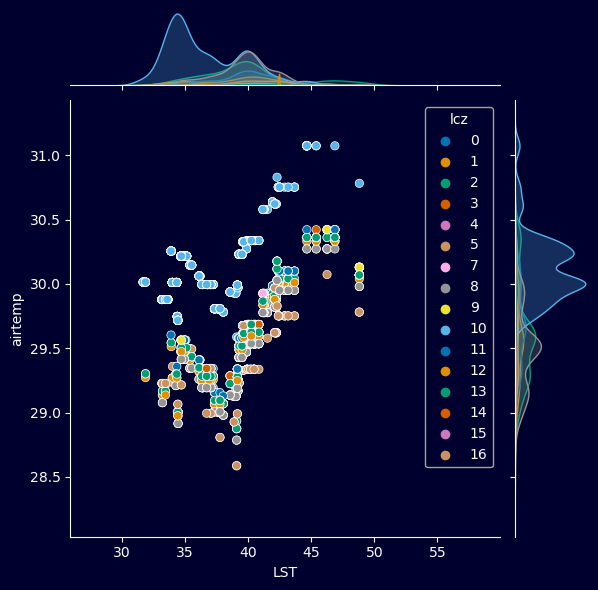

In [981]:
sns.jointplot(prediction_df, x='LST', y='airtemp', hue='lcz', palette='colorblind');

----

## Visualisation Product

We add the layers onto a folium map to construct the complete interactive visualisation product

### Add to Feature Collection - Air Temperature and LCZ

In [867]:
# convert airtemp into ee.List object for easier manipulation
airtemp_list = ee.List(list(prediction_df['airtemp']))

In [858]:
# convert lcz into ee.List object for easier manipulation
lcz_list = ee.List(list(prediction_df['lcz']))

In [868]:
# convert ee.FeatureCollection into list for easier manipulation
sgmap_grid_lst_list = sgmap_grid_lst.toList(sgmap_grid_lst.size())

In [884]:
def set_airtemp_lcz_features(idx):
    '''
    Function that sets the airtemp property (airtemp_list) of the 'idx'th feature in the list of features (sgmap_grid_lst_list)
    '''
    
    return ee.Feature(sgmap_grid_lst_list.get(idx)).set({'lcz': lcz_list.get(idx), 'airtemp': airtemp_list.get(idx)})
    

In [886]:
# create placeholder ee.List to insert lcz and airtemp into full_fc
full_fc = ee.List.sequence(0, sgmap_grid_lst_list.size().subtract(1))

In [887]:
# insert lcz as a property of each feature and convert the ee.list back to ee.FeatureCollection
full_fc = ee.FeatureCollection(full_fc.map(set_airtemp_lcz_features))

### Add to Folium Map

In [1007]:
# define the airtemp layer
# set the color scale
airtemp_cm = folium.branca.colormap.linear.RdYlGn_08
airtemp_cm.colors.reverse()
airtemp_cm = airtemp_cm.scale(vmin=prediction_df['airtemp'].min(),
                              vmax=prediction_df['airtemp'].max())
airtemp_cm = airtemp_cm.to_step(n=20)
airtemp_cm.caption = 'Air Temperature'
airtemp_cm_list = [to_hex(c) for c in airtemp_cm.colors] # convert colormap object into hex strings

# convert FeatureCollection to Image for easier plotting
empty = ee.Image().byte() # just an empty "Image"
airtemp_img = empty.paint(full_fc, 'airtemp')

# set vis params for airtemp
vis_params_airtemp = {
    'palette': airtemp_cm_list,
    'min': prediction_df['airtemp'].min(),
    'max': prediction_df['airtemp'].max()
}


In [997]:
# define the lcz layer
# set the color scale
lcz_cm = folium.branca.colormap.linear.Set1_08.to_step(n=17)
lcz_cm_list = [to_hex(c) for c in lcz_cm.colors] # convert colormap object into hex strings

# convert FeatureCollection to Image for easier plotting
empty = ee.Image().byte() # just an empty "Image"
lcz_img = empty.paint(full_fc, 'lcz')

# set vis params for lcz
vis_params_lcz = {
    'palette': lcz_cm_list,
    'min': 0,
    'max': 17
}


In [998]:
# define the sen2 layer
vis_params_sen2 = {
    'bands': ['B4', 'B3', 'B2'],
    'min': 0,
    'max': 4000
}

In [999]:
# define the LST layer
lst_cm = folium.branca.colormap.linear.RdYlGn_08
lst_cm.colors.reverse()
lst_cm = lst_cm.scale(vmin=30,
                      vmax=55)
lst_cm = lst_cm.to_step(n=20)
lst_cm.caption = 'Land Surface Temperature'
lst_cm_list = [to_hex(c) for c in lst_cm.colors] # convert colormap object into hex strings

vis_params_lst = {
    'bands': ['LST_1KM'],
    'min': 30,
    'max': 55,
    'palette': lst_cm_list
}

In [1009]:
%%time
# initialise map for date-of-interest plot
m_doi = folium.Map(location=get_centroid_coord(singapore_bounds.geometry()), zoom_start=11)

# add LST layer
m_doi.add_ee_layer(ee_image_object = modis_doi.expression('LST - 273.15', {'LST': modis_doi.select('LST_1KM')}).clip(sgmap_grid_lst.geometry()).clip(sgmap), 
                   vis_params = vis_params_lst, 
                   name = 'Land Surface Temperature', 
                   opacity = 0.6)

# add SEN2 layer
m_doi.add_ee_layer(ee_image_object = sen2_doi.clip(sgmap_grid_lst.geometry()).clip(sgmap), 
                   vis_params = vis_params_sen2, 
                   name = 'Satellite Composite', 
                   opacity = 1.)

# add LCZ layer
m_doi.add_ee_layer(ee_image_object = lcz_img.clip(sgmap_grid_lst.geometry()).clip(sgmap), 
                   vis_params = vis_params_lcz, 
                   name = 'LCZ', 
                   opacity = 0.6)

# add air temp layer
m_doi.add_ee_layer(ee_image_object = airtemp_img.clip(sgmap), 
                   vis_params = vis_params_airtemp, 
                   name = 'Air Temperature', 
                   opacity = 0.6)

# add colorbars
airtemp_cm.add_to(m_doi)
lst_cm.add_to(m_doi)

CPU times: user 175 ms, sys: 3.81 ms, total: 179 ms
Wall time: 38.8 s


### Visualisation

In [1010]:
m_doi.add_child(folium.LayerControl('topleft'))

display(m_doi)

### Save Visualisation

In [1011]:
m_doi.save('../images/visualisation_product.html')